In [177]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn import svm
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
from sklearn.metrics import roc_auc_score, roc_curve, plot_precision_recall_curve, classification_report
from sklearn.metrics import auc as auc_score 
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification

import warnings
warnings.simplefilter('ignore')

In [178]:
df = pd.read_csv("lung_cancer.csv", encoding="utf8", sep=',')

In [179]:
def preprocessing(df):
    df.replace({1: 0, 2: 1}, inplace=True)
    df.replace({"YES": 1, "NO": 0}, inplace=True)
    df.replace({"M": 1, "F": 0}, inplace=True)
    scaler = MinMaxScaler()
    df['AGE'] = scaler.fit_transform(df[['AGE']])
    return df

In [180]:
df = preprocessing(df)
num_rows, num_cols = df.shape
print(df[:5].to_string(), '\n',
      df.shape)

   GENDER       AGE  SMOKING  YELLOW_FINGERS  ANXIETY  PEER_PRESSURE  CHRONIC DISEASE  FATIGUE   ALLERGY   WHEEZING  ALCOHOL CONSUMING  COUGHING  SHORTNESS OF BREATH  SWALLOWING DIFFICULTY  CHEST PAIN  LUNG_CANCER
0       1  0.727273        0               1        1              0                0         1         0         1                  1         1                    1                      1           1            1
1       1  0.803030        1               0        0              0                1         1         1         0                  0         0                    1                      1           1            1
2       0  0.575758        0               0        0              1                0         1         0         1                  0         1                    1                      0           1            0
3       1  0.636364        1               1        1              0                0         0         0         0                  1         0

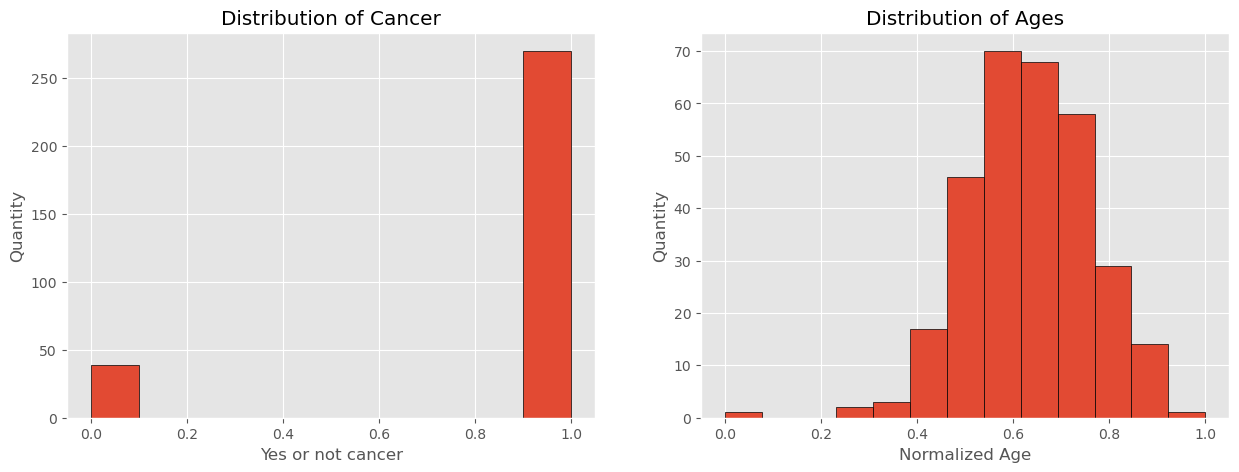

In [181]:
plt.style.use('ggplot')
plt.figure(figsize=(15, 5))
plt.subplot (1, 2, 1)
plt.hist(df['LUNG_CANCER'], edgecolor='black')
plt.title('Distribution of Cancer')
plt.xlabel('Yes or not cancer')
plt.ylabel('Quantity')
plt.subplot (1, 2, 2)
plt.hist(df['AGE'], bins=13, edgecolor='black')
plt.title('Distribution of Ages')
plt.xlabel('Normalized Age')
plt.ylabel('Quantity')
plt.show()

In [182]:
# Разделение данных на обучающую, проверочную и выборку для тестирования
X = df.drop('LUNG_CANCER', axis=1)
y = df['LUNG_CANCER']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Обучите модель SVM
svm_model = svm.SVC(probability=True)
svm_model.fit(X_train, y_train)

# Сделайте прогнозы и выведите отчет о классификации для модели SVM
svm_predictions = svm_model.predict(X_test)
print("Отчет о классификации для модели SVM:")
print(classification_report(y_test, svm_predictions))

# Обучите модель градиентного бустинга
gb_model = GradientBoostingClassifier()
gb_model.fit(X_train, y_train)

# Сделайте прогнозы и выведите отчет о классификации для модели градиентного бустинга
gb_predictions = gb_model.predict(X_test)
print("Отчет о классификации для модели GB:")
print(classification_report(y_test, gb_predictions))

Отчет о классификации для модели SVM:
              precision    recall  f1-score   support

           0       0.83      0.71      0.77         7
           1       0.98      0.99      0.98        86

    accuracy                           0.97        93
   macro avg       0.91      0.85      0.88        93
weighted avg       0.97      0.97      0.97        93

Отчет о классификации для модели GB:
              precision    recall  f1-score   support

           0       0.80      0.57      0.67         7
           1       0.97      0.99      0.98        86

    accuracy                           0.96        93
   macro avg       0.88      0.78      0.82        93
weighted avg       0.95      0.96      0.95        93



In [183]:
model = svm_model
# Вычисление вероятностей классов
probs = model.predict_proba(X_test)
# Вычисление AUC-ROC
auc = roc_auc_score(y_test, probs[:,1])
print('AUC: %.2f' % auc)

AUC: 0.99


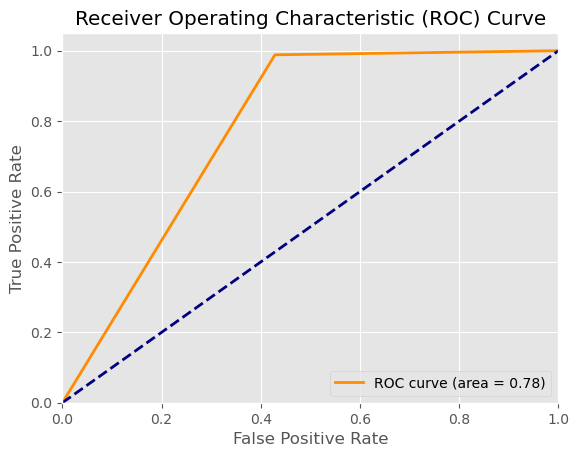

In [184]:
y_true = y_test
y_scores = gb_predictions
# Кривая ошибок (ROC curve) и площадь под кривой (AUC)
fpr, tpr, _ = roc_curve(y_true, y_scores)
roc_auc = auc_score(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")


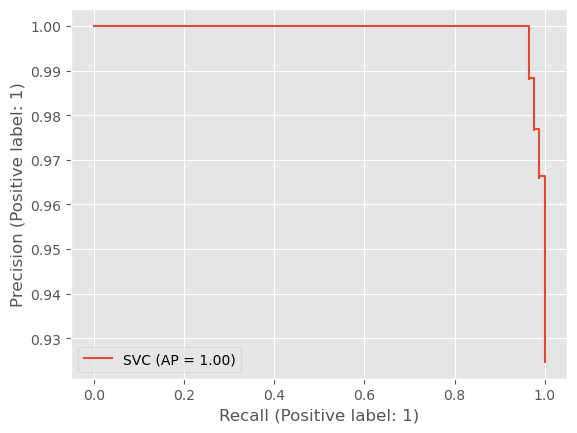

In [185]:
plot_precision_recall_curve(model, X_test, y_test)
plt.show()

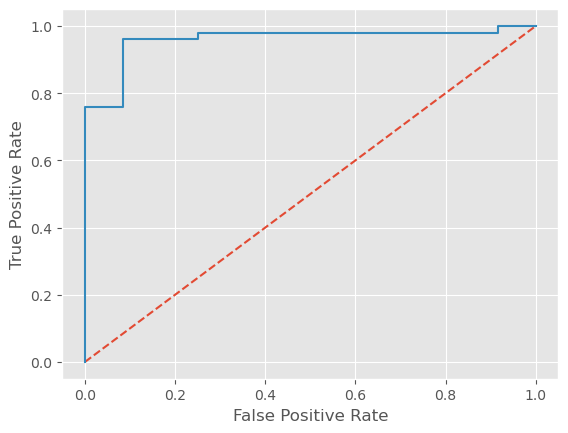

In [186]:
# Разбиение данных
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

# Обучение модели и вычисление вероятностей классов для валидационной выборки
model.fit(X_train, y_train)
probs = model.predict_proba(X_val)

# Построение ROC-кривой
fpr, tpr, thresholds = roc_curve(y_val, probs[:,1])
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()


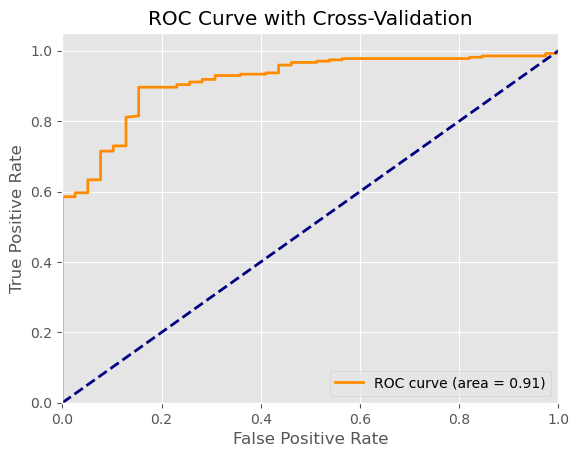

In [187]:
from sklearn.model_selection import cross_val_predict
# Построение ROC-кривой на основе кросс-валидации
y_scores_cv = cross_val_predict(model, X, y, cv=5, method='predict_proba')[:, 1]

fpr_cv, tpr_cv, thresholds_cv = roc_curve(y, y_scores_cv)
roc_auc_cv = auc_score(fpr_cv, tpr_cv)

plt.figure()
plt.plot(fpr_cv, tpr_cv, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_cv)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve with Cross-Validation')
plt.legend(loc="lower right")
plt.show()

In [188]:
import numpy as np
from sklearn.metrics import roc_auc_score, recall_score, precision_score, f1_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.utils import shuffle
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis, LinearDiscriminantAnalysis
from sklearn.mixture import GaussianMixture
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier

metric_names = ['roc_auc_score', 'recall_score', 'precision_score', 'f1_score', 'log_likelihood']
def train_and_evaluate(model, X_train, y_train, X_test, y_test, params, metric):
    if isinstance(model, GaussianMixture):
        model.fit(X_train)
        log_likelihood = model.score(X_test)
        return model.get_params(), log_likelihood
    else:
        grid_search = GridSearchCV(model, params, cv=5, scoring=globals()[metric])
        grid_search.fit(X_train, y_train)
        y_pred = grid_search.best_estimator_.predict(X_test)
        return grid_search.best_params_,  globals()[metric](y_test, y_pred)

num = len(X)
X_shuffled, y_shuffled = shuffle(X, y, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_shuffled[:num], y_shuffled[:num], test_size=0.5, random_state=42, stratify=y_shuffled[:num])

# Список моделей с параметрами и метриками
models_params_metrics = [

     (SVC(), {'C': [0.01, 0.1, 0.5, 1, 2, 3, 5, 10, 100], 'kernel': ['linear', 'rbf', 'poly', 'sigmoid'], 
             'gamma': ['scale', 'auto'], 
             'class_weight': ['balanced', {0: 1, 1: 0.05}, {0: 1, 1: 0.1}, {0: 1, 1: 0.3}, {0: 1, 1: 0.5}, {0: 2, 1: 0.5},
                                         {0: 3, 1: 0.5}, {0: 6, 1: 0.5},{0: 6, 1: 1}, {0: 3, 1: 1}, {0: 2, 1: 1}]}, 
                metric_names[:4]),
    
    (XGBClassifier(), {'scale_pos_weight': [(len(y_train) - sum(y_train)) / sum(y_train)]}, metric_names[:4]),

    (LinearDiscriminantAnalysis(), {'solver': ['svd', 'lsqr', 'eigen']}, metric_names[:4]),

    (GradientBoostingClassifier(), {'learning_rate':[0.01, 0.05, 0.1, 0.2, 0.5, 1], 'n_estimators':[30, 50, 100, 300]}, metric_names[:4]),

    (LogisticRegression(), {'C': [0.01, 0.05, 0.1, 0.5, 1, 2, 5, 10, 30, 50, 100], 'solver': ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'],
                            'class_weight': ['balanced', {0: 1, 1: 0.05}, {0: 1, 1: 0.1}, {0: 1, 1: 0.3}, {0: 1, 1: 0.5}, {0: 2, 1: 0.5}, 
                                                 {0: 3, 1: 0.5}, {0: 6, 1: 0.5}, {0: 6, 1: 1}, {0: 3, 1: 1}, {0: 2, 1: 1}],
                            'max_iter': [50, 100, 150, 200]}, metric_names[:4]),

    (GaussianMixture(), {'n_components': [2, 3, 4, 5], 'covariance_type': ['full', 'tied', 'diag', 'spherical']}, metric_names[4:]),

    (RandomForestClassifier(), {'criterion': ['entropy', 'gini', 'log_loss'], 'n_estimators': [30, 50, 100, 300],
                                'class_weight': [{0: 1, 1: 0.05}, {0: 1, 1: 0.1}, {0: 1, 1: 0.3}, {0: 1, 1: 0.5}, {0: 2, 1: 0.5}, 
                                                 {0: 3, 1: 0.5}, {0: 6, 1: 0.5}, {0: 6, 1: 1}, {0: 3, 1: 1}, {0: 2, 1: 1},
                                                 'balanced', 'balanced_subsample']}, metric_names[:4]),

    (KNeighborsClassifier(), {'n_neighbors': [3, 5, 7, 10, 15], 'weights': ['uniform', 'distance']}, metric_names[:4]),

    (GaussianNB(), {}, metric_names[:4]),

    (QuadraticDiscriminantAnalysis(), {'reg_param': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]}, metric_names[:4])
]

data_score = []

# Перебор моделей с параметрами и метриками
for model, params, model_metrics in models_params_metrics:
    model_name = model.__class__.__name__
    print(f'{model_name} is training...')
    for metric in model_metrics:
        result_params, score = train_and_evaluate(model, X_train, y_train, X_test, y_test, params, metric)
        data_score.append((model_name, metric, result_params, score))


SVC is training...
XGBClassifier is training...
LinearDiscriminantAnalysis is training...
GradientBoostingClassifier is training...


KeyboardInterrupt: 

In [ ]:
df_models = pd.DataFrame(data_score, columns=['model_name', 'metric', 'model_params', 'score'])
df_models.to_csv('data_models.csv', index=False)

for metric in metric_names:
    sorted_data = sorted(data_score, key=lambda x: x[3] if x[1] == metric else float('inf'))
    print(f"Топ 3 модели в категории {metric}")
    top_models = sorted_data[:3]
    top_models = [item for item in top_models if item[1] == metric]

    for model in top_models:
        print(f'Имя модели {model[0]}, оценка метрики {model[3]}, параметры модели {model[2]}')
    print()

Топ 3 модели в категории roc_auc_score
Имя модели GradientBoostingClassifier, оценка метрики 0.5, параметры модели {'learning_rate': 0.01, 'n_estimators': 30}
Имя модели QuadraticDiscriminantAnalysis, оценка метрики 0.6601851851851852, параметры модели {'reg_param': 0.0}
Имя модели KNeighborsClassifier, оценка метрики 0.7388888888888889, параметры модели {'n_neighbors': 3, 'weights': 'uniform'}

Топ 3 модели в категории recall_score
Имя модели SVC, оценка метрики 0.8222222222222222, параметры модели {'C': 0.01, 'class_weight': 'balanced', 'gamma': 'scale', 'kernel': 'linear'}
Имя модели LogisticRegression, оценка метрики 0.9037037037037037, параметры модели {'C': 0.01, 'class_weight': 'balanced', 'max_iter': 50, 'solver': 'lbfgs'}
Имя модели XGBClassifier, оценка метрики 0.9333333333333333, параметры модели {'scale_pos_weight': 0.14074074074074075}

Топ 3 модели в категории precision_score
Имя модели GradientBoostingClassifier, оценка метрики 0.8709677419354839, параметры модели {'lear

  0%|          | 0/234 [00:00<?, ?it/s]

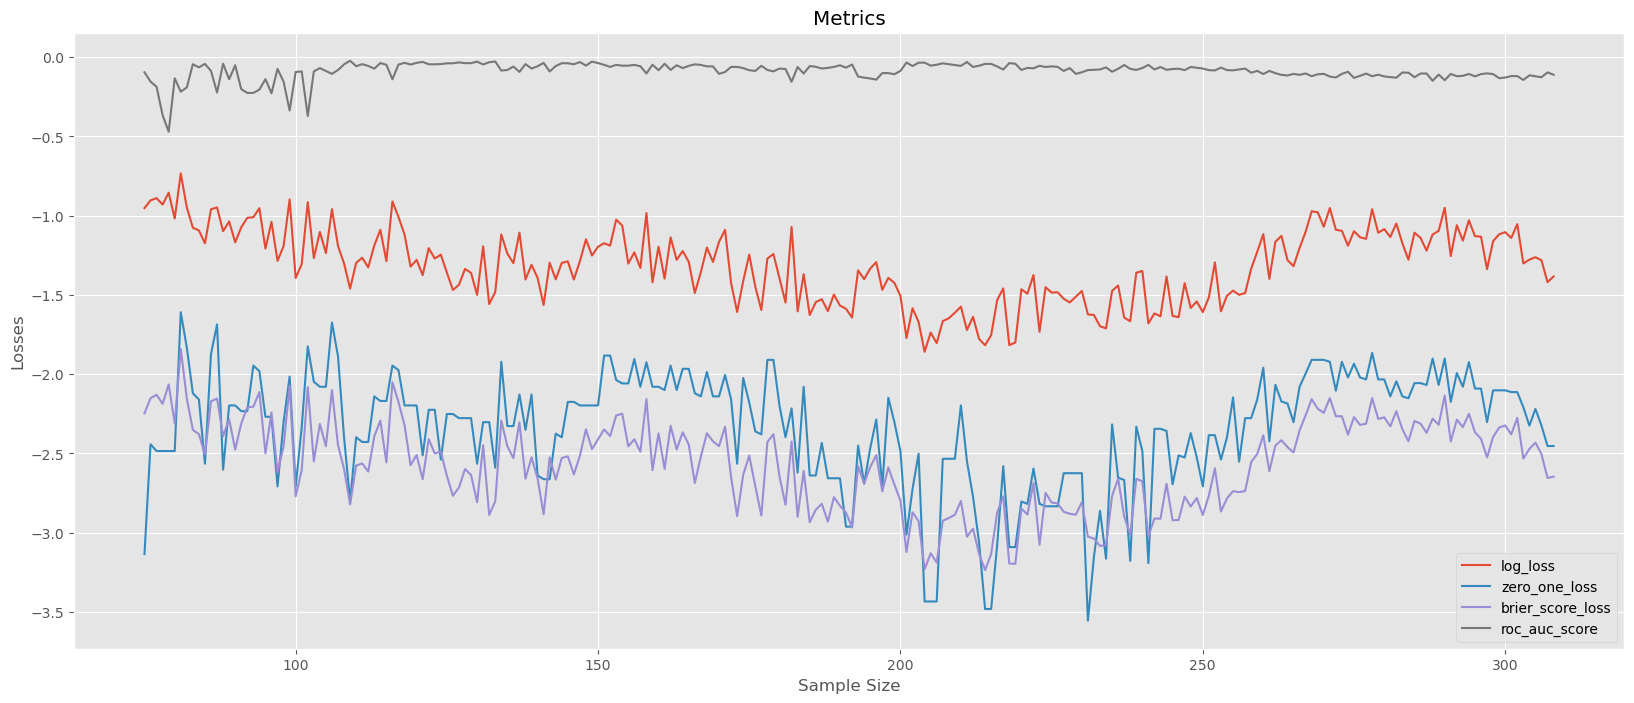

In [ ]:
from sklearn.metrics import log_loss, zero_one_loss, brier_score_loss, roc_auc_score
from tqdm.notebook import tqdm


X_shuffled, y_shuffled = shuffle(X, y, random_state=42)

vals = np.arange(75, len(X))

metrics = [log_loss, zero_one_loss, brier_score_loss, roc_auc_score]
metric_dict = {loss_function: [] for loss_function in metrics}

for num in tqdm(vals):
    #model = RandomForestClassifier(class_weight = {0: 1, 1: 0.05}, criterion= 'entropy', n_estimators= 30)
    #model = KNeighborsClassifier(n_neighbors= 3, weights= 'uniform')
    #model = LogisticRegression(C= 0.01, class_weight='balanced', max_iter=50, solver='lbfgs')
    #model = GaussianMixture(covariance_type='full', n_components=2)
    model = XGBClassifier(scale_pos_weight= 0.14074074074074075) # recall_score winner
    
    X_train, X_test, y_train, y_test = train_test_split(X_shuffled[:num], y_shuffled[:num], test_size=0.3, random_state=42, stratify=y_shuffled[:num])
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)
    for metric in metrics:
        if metric is zero_one_loss:
            loss = metric(y_test, y_pred)
        else:
            loss = metric(y_test, y_proba[:, 1])
        metric_dict[metric].append(loss)
plt.figure(figsize=(20,8))
for metric in metrics:
    loss = metric(y_test, y_pred)
    plt.plot(vals, np.log(metric_dict[metric]), label=metric.__name__)
plt.legend()
plt.title("Metrics")
plt.xlabel("Sample Size")
plt.ylabel("Losses")
plt.show()